# Mushroom Classification Using Different Classifiers (Project Work)

In this project, we explore the Secondary Mushroom dataset and build machine learning models to predict whether a mushroom is edible or poisonous based on its observed characteristics (such as cap diameter, cap shape/color, gill properties, odor, habitat, and other attributes).

The dataset used in this notebook is secondary_data.csv (loaded with ; as the separator) and contains 61,069 samples with 20 input features (a mix of categorical attributes and a few numerical measurements like cap-diameter, stem-height, and stem-width). After preprocessing (handling missing values and encoding categorical features), we train and compare three classifiers: K-Nearest Neighbors (KNN), Support Vector Machine (SVM), and Naive Base, and evaluate them on a held-out test set.

## 1. Importing the packages

In [38]:
# Data & numerical computing
import numpy as np
import pandas as pd
from pandas.util import hash_pandas_object

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD

# Utilities
import os

# Scikit-learn: preprocessing & pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

# Scikit-learn: model selection & evaluation
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate,
    GroupKFold, GridSearchCV
)
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report
)

# Scikit-learn: models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

# Statistical tests
from scipy.stats import chi2_contingency


## 2. Read the csv file of the dataset

Load the dataset by reading the CSV file into a pandas DataFrame.

In [2]:
df = pd.read_csv("secondary_data.csv",sep= ";")

## 3. Examining and Manipulating the Data

In this section, we perform an initial exploration of the dataset using methods such as `.head()`, `.info()`, and `.describe()` to inspect sample rows, check data types and missing values, and summarize key statistics. We also clean the data by identifying and removing duplicate rows to ensure the dataset is consistent before modeling.

In [3]:
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [5]:
df.describe()

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


In [6]:
#number of duplicates in the dataframe
n_dups = df.duplicated().sum()
print(f"Number of duplicate rows before: {n_dups}")

Number of duplicate rows before: 146


In [7]:
# Drop the duplicates to have more clean dataset
df_no_dups = df.drop_duplicates()
n_dups_after = df_no_dups.duplicated().sum()
print(f"Number of duplicate rows after: {n_dups_after}")

Number of duplicate rows after: 0


I removed duplicate rows to prevent repeated samples from biasing the training and evaluation results. Keeping only unique observations makes the dataset cleaner and helps the models learn patterns that generalize better.

## 4. Shape of dataset

In [8]:
print(f"Dataset shape: {df_no_dups.shape}")

Dataset shape: (60923, 21)


## 5. Class Distribution: Edible vs. Poisonous

In this section, we count how many mushrooms belong to each class (edible and poisonous) to understand the dataset balance. This helps us interpret evaluation results and choose appropriate validation strategies.

In [9]:
df_no_dups['class'].value_counts()

,count
class,
p,33742
e,27181


In [10]:
df_no_dups['class'].unique()

array(['p', 'e'], dtype=object)

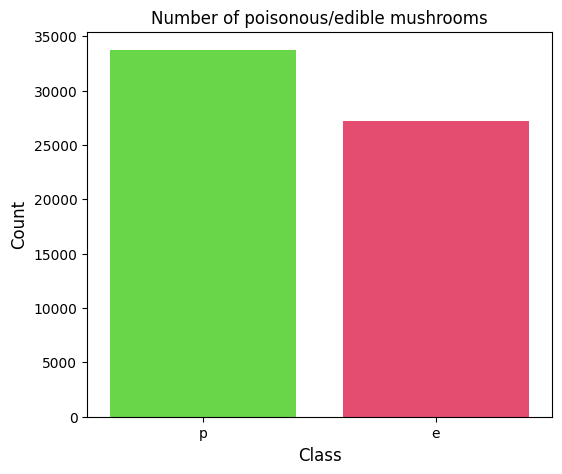

In [11]:
count = df_no_dups['class'].value_counts()
plt.figure(figsize=(6,5))
sns.barplot(x= count.index, y= count.values, hue=count.index, alpha=0.8, palette="prism", legend= False)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.title('Number of poisonous/edible mushrooms')
plt.show();

## 6. Visualizing the Data

### 6.1. Preparing the Data for Visualization

In this step, we create a separate copy of the cleaned dataset for visualization and convert the target label (class) into numeric form (e → 0, p → 1). We then split the predictors into numerical features (cap-diameter, stem-height, stem-width) and categorical features (all remaining columns). To make the dataset plot-ready, missing values in categorical columns are replaced with a "missing" category, categorical variables are temporarily ordinal-encoded, and numerical variables are standardized to keep feature ranges comparable in plots.

In [ ]:
df_plot = df_no_dups.copy()

# target
df_plot["class"] = df_plot["class"].map({"e": 0, "p": 1})

# features
X = df_plot.drop(columns=["class"])

num_cols = ["cap-diameter", "stem-height", "stem-width"]
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric:", num_cols)
print("Categorical:", cat_cols)


Numeric: ['cap-diameter', 'stem-height', 'stem-width']
Categorical: ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


In [ ]:
df_enc = df_plot.copy()

# fill NaNs in categoricals to make "missing" an explicit category
df_enc[cat_cols] = df_enc[cat_cols].fillna("missing")

# ordinal encode categoricals (temporary for plotting)
oe = OrdinalEncoder()
df_enc[cat_cols] = oe.fit_transform(df_enc[cat_cols])

# scale numeric (optional but makes violin ranges nicer)
scaler = StandardScaler()
df_enc[num_cols] = scaler.fit_transform(df_enc[num_cols])

df_enc.head()


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,1,1.616820,6.0,2.0,6.0,0.0,2.0,3.0,10.0,3.082356,...,5.0,8.0,11.0,1.0,5.0,1.0,2.0,2.0,0.0,3.0
1,1,1.871167,6.0,2.0,6.0,0.0,2.0,3.0,10.0,3.391996,...,5.0,8.0,11.0,1.0,5.0,1.0,2.0,2.0,0.0,2.0
2,1,1.390945,6.0,2.0,6.0,0.0,2.0,3.0,10.0,3.335427,...,5.0,8.0,11.0,1.0,5.0,1.0,2.0,2.0,0.0,3.0
3,1,1.409926,2.0,3.0,1.0,0.0,2.0,3.0,10.0,2.731032,...,5.0,8.0,11.0,1.0,5.0,1.0,6.0,2.0,0.0,3.0
4,1,1.499137,6.0,3.0,6.0,0.0,2.0,3.0,10.0,2.957308,...,5.0,8.0,11.0,1.0,5.0,1.0,6.0,2.0,0.0,3.0


#### 6.2. Box Plot (Numeric Features vs. Class)
We use box plots to compare the distribution of numerical features between edible (e) and poisonous (p) mushrooms. A box plot highlights the median, spread (IQR), and outliers, making it easy to see whether the two classes differ in typical values or variability. We only plot three columns because they are the only continuous numeric features in this dataset (cap-diameter, stem-height, stem-width); the remaining features are categorical, so box plots are not appropriate for them.

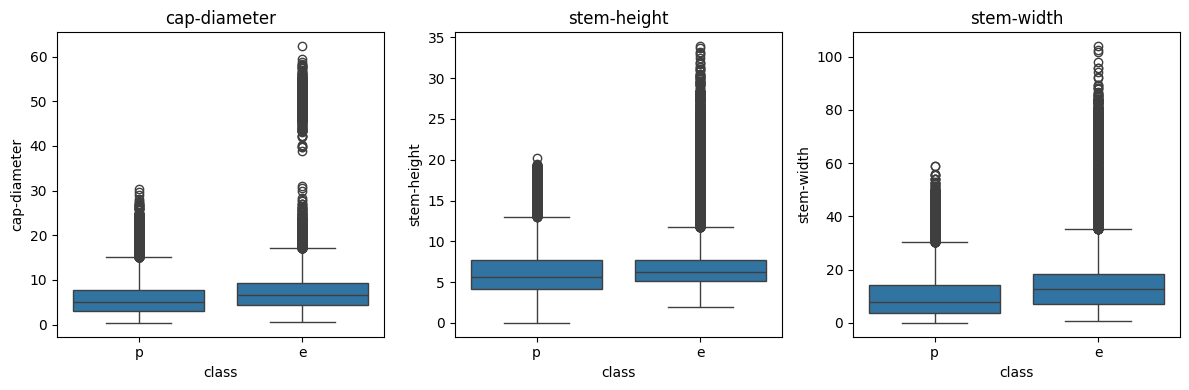

In [ ]:
num_cols = ["cap-diameter", "stem-height", "stem-width"]

plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df, x="class", y=col)
    plt.title(col)
plt.tight_layout()
plt.show()


**Conclusion**:
From the plots, edible mushrooms generally show slightly higher median values for cap diameter, stem height, and stem width compared to poisonous ones, although the distributions overlap considerably. All three features contain many outliers, suggesting wide natural variation in mushroom size.

#### 6.3. Correlation Heatmap (Ordinal-Encoded Features)
We use a correlation heatmap to get a quick overview of how features relate to each other and to the target class. Since most variables are categorical, they are temporarily ordinal-encoded only for visualization so that a correlation matrix can be computed (this does not imply a true numeric order in the original categories).

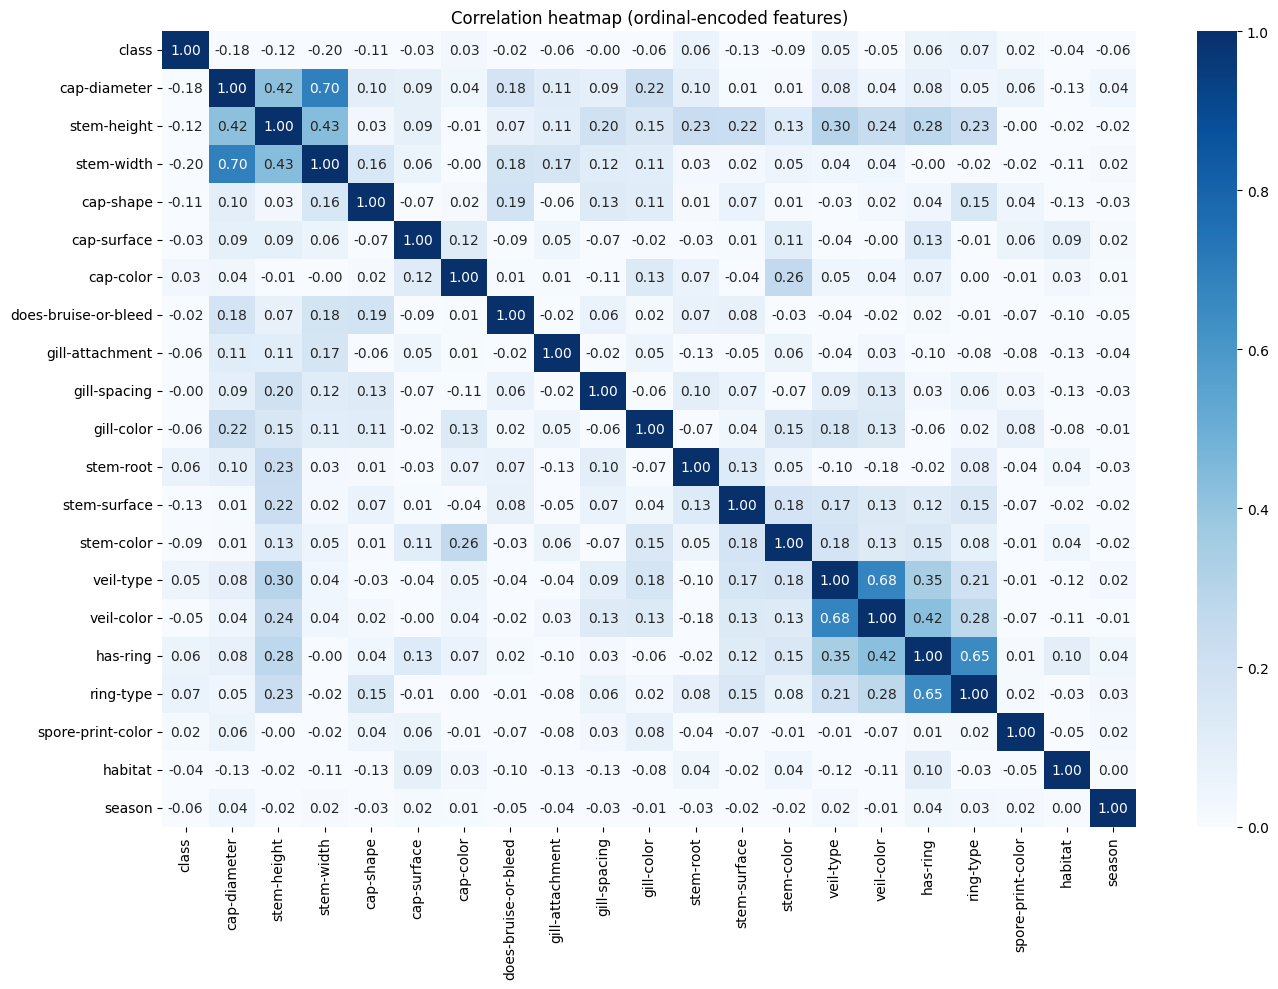

In [ ]:
# Build the list of columns to include in the correlation matrix
cols_for_corr = ["class"] + num_cols + cat_cols

# Correlation on the temporary ordinal-encoded dataset (for visualization only)
corr = df_enc[cols_for_corr].corr(numeric_only=True)

# Plot correlation heatmap (values scaled between 0 and 1 for readability)
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="Blues", vmin=0, vmax=1, annot=True, fmt=".2f")
plt.title("Correlation heatmap (ordinal-encoded features)")
plt.tight_layout()
plt.show()


**Conclusion**:
Overall, the target class shows weak linear correlations with most individual features, suggesting that edibility is likely determined by combinations of attributes rather than a single feature. The heatmap also highlights a few strong correlations between some features (e.g., some size measurements and some related categorical attributes), which may indicate redundancy—something tree-based models can handle well but that is still useful to know during analysis

#### 6.4. Categorical Association Heatmap (Cramér’s V)
Because the majority of variables in this dataset are categorical, a standard correlation matrix (Pearson) is not appropriate. Instead, we compute Cramér’s V, which measures the strength of association between two categorical features on a scale from 0 (no relationship) to 1 (very strong relationship). We also include the target (class) to see which attributes are most related to edibility/poisonousness, and we plot a selected subset of columns to keep the heatmap readable.

In this step, we replace `?` and `NaN` values with a separate `missing` label only for the categorical association analysis, so the chi-square contingency tables can be computed without dropping rows.

In [ ]:
def cramers_v(x, y):
    # Cramér’s V (0..1): strength of association between two categorical variables
    table = pd.crosstab(x, y)
    chi2 = chi2_contingency(table, correction=False)[0]
    n = table.to_numpy().sum()

    # Bias-corrected version
    r, k = table.shape
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)

    denom = min(kcorr - 1, rcorr - 1)
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

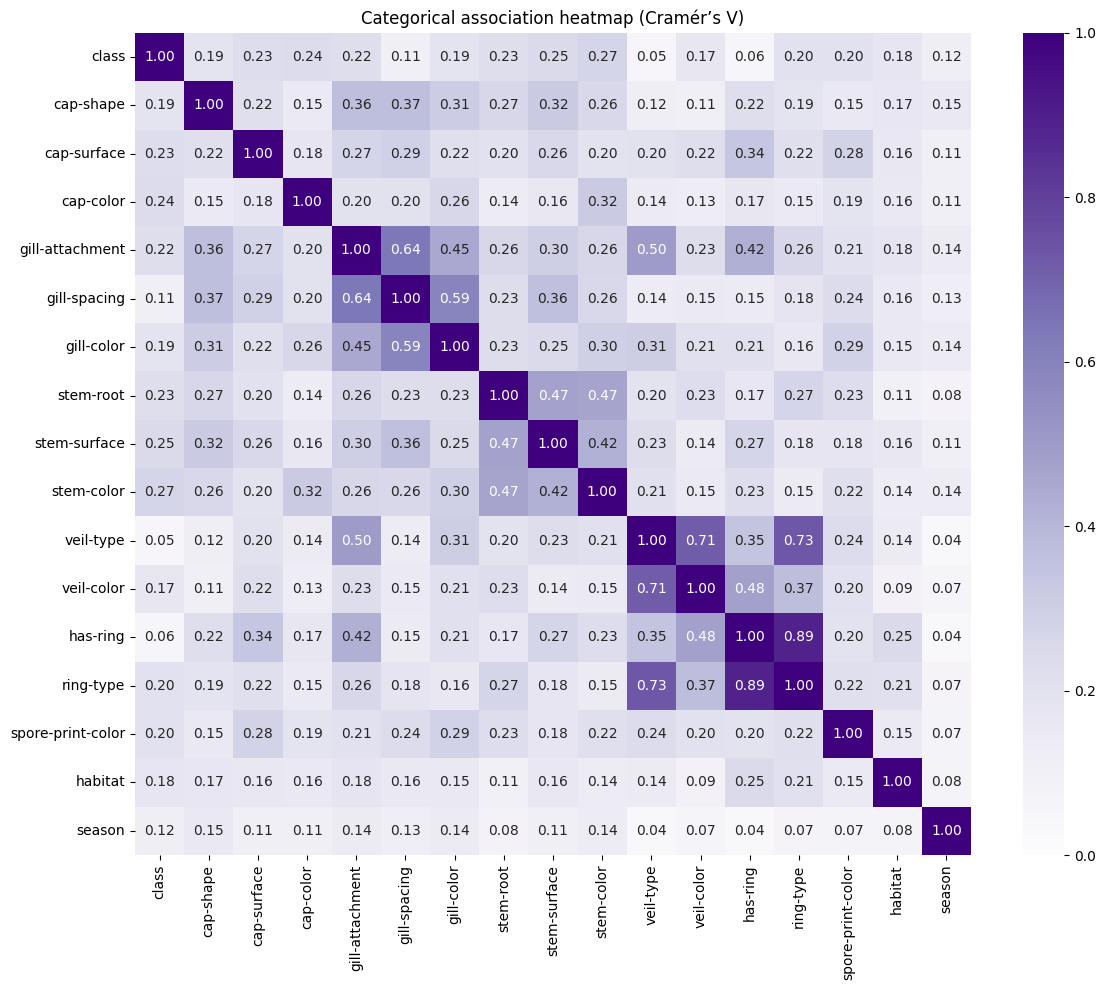

In [ ]:
# Prepare categorical data (include target 'class')
df_cat = df_no_dups[cat_cols + ["class"]].copy()
df_cat = df_cat.replace("?", np.nan).fillna("missing")

# Subset of columns to keep the heatmap readable
subset = ["class", "cap-shape", "cap-surface", "cap-color",
          "gill-attachment", "gill-spacing", "gill-color",
          "stem-root", "stem-surface", "stem-color",
          "veil-type", "veil-color",
          "has-ring", "ring-type",
          "spore-print-color", "habitat", "season"]
subset = [c for c in subset if c in df_cat.columns]

# Compute pairwise Cramér’s V matrix
V = pd.DataFrame(index=subset, columns=subset, dtype=float)
for c1 in subset:
    for c2 in subset:
        V.loc[c1, c2] = cramers_v(df_cat[c1], df_cat[c2])

# Plot association heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(V, annot=True, fmt=".2f", cmap="Purples", vmin=0, vmax=1)
plt.title("Categorical association heatmap (Cramér’s V)")
plt.tight_layout()
plt.show()


**Conclusion:**
The class row/column shows mostly weak-to-moderate associations with individual features (around 0.05–0.27 in this subset), suggesting that the target is not determined by a single categorical attribute but rather by combinations of multiple features. The heatmap also reveals some strong dependencies between predictors, such as has-ring ↔ ring-type (≈ 0.89) and veil-type ↔ veil-color (≈ 0.71), indicating overlapping information among certain variables—useful context when interpreting the dataset and model behavior.

## 7. Data Preprocessing and Train/Test Split

In this section, we prepare the dataset for modeling by:

* Creating a clean working copy and separating features (X) from the target (y), mapping class to numeric labels (e → 0, p → 1).

* Splitting the predictors into numeric (cap-diameter, stem-height, stem-width) and categorical columns, and converting "?" in categorical fields into missing values.

* Performing a stratified train/test split (80/20) to preserve the class distribution in both sets.

* Building consider pipeline-based preprocessing:

  * Numeric: median imputation + standardization

  * Categorical: fill missing with "missing" + one-hot encoding (ignoring unseen categories)

* Fitting the preprocessing on the training set and transforming both train and test data into model-ready numeric matrices.

In [12]:
# Copy data and split into features/target (encode class: e=0, p=1)
df_prep = df_no_dups.copy()
y = df_prep["class"].map({"e": 0, "p": 1})
X = df_prep.drop(columns=["class"])

# Separate numeric and categorical columns + mark "?" as missing in categoricals
num_cols = ["cap-diameter", "stem-height", "stem-width"]
cat_cols = [c for c in X.columns if c not in num_cols]
X[cat_cols] = X[cat_cols].replace("?", np.nan)

print("X shape:", X.shape)
print("Numeric:", num_cols)
print("Categorical:", len(cat_cols))

X shape: (60923, 20)
Numeric: ['cap-diameter', 'stem-height', 'stem-width']
Categorical: 17


In [13]:
# Stratified train/test split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)

(48738, 20) (12185, 20)


In [14]:
# Preprocessing pipelines: numeric (impute+scale), categorical (impute+one-hot)
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing for numeric + categorical columns
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

In [15]:
# Fit on training data, then transform train and test (Just to check their shape)
X_train_tr = preprocess.fit_transform(X_train)
X_test_tr = preprocess.transform(X_test)

print("Train transformed:", X_train_tr.shape)
print("Test transformed:", X_test_tr.shape)


Train transformed: (48738, 128)
Test transformed: (12185, 128)


## 8. Classification Methods

In this section, we train and compare three classifiers —  K-Nearest Neighbors(KNN), Support Vector Machine (SVM) and Naive Base—to predict mushroom edibility. Each model is evaluated on the same train/test split to measure performance and identify the best approach.

In [16]:
# Store model results for later comparison
all_models = []

### 8.1. K-Nearest Neighbors (KNN)

#### 8.1.1. Hyperparameter tuning (searching for the best k)

In this section, I tune the main hyperparameter of KNN: the number of neighbors (k).
Because KNN is sensitive to the choice of k, I evaluate several values and select the one that performs best.

To make the comparison reliable, I use 5-fold Stratified Cross-Validation on the training set. Stratification ensures that each fold keeps a similar proportion of edible vs. poisonous mushrooms. For each k, I compute three evaluation metrics:

* Accuracy (%)

* F1-score

* ROC-AUC

All results are stored in a table and visualized with a plot (F1-score vs. k) to clearly show how performance changes with different neighborhood sizes.



**NOTE:** Since this cross-validation step takes about 20 minutes on my machine, I keep the code for reproducibility but comment it out during reruns, leaving the saved output (table/plot) to show the results.

In [17]:
# k_values = list(range(1,11))

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# rows = []

# for k in k_values:
#     knn_pipe = Pipeline(steps=[
#         ("prep", preprocess),
#         ("clf", KNeighborsClassifier(n_neighbors=k, weights="distance"))
#     ])

#     scores = cross_validate(knn_pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

#     rows.append({
#         "k": k,
#         "accuracy_%": scores["test_accuracy"].mean() * 100,
#         "f1_score": scores["test_f1"].mean(),
#         "roc_auc": scores["test_roc_auc"].mean(),
#     })

In [18]:
# knn_k_results = pd.DataFrame(rows).sort_values("f1_score", ascending=False).reset_index(drop=True)
# knn_k_results.head(10)

,k,accuracy_%,f1_score,roc_auc
0,1,100.0,1.0,1.0
1,2,100.0,1.0,1.0
2,3,100.0,1.0,1.0
3,4,100.0,1.0,1.0
4,5,100.0,1.0,1.0
5,6,100.0,1.0,1.0
6,7,100.0,1.0,1.0
7,8,100.0,1.0,1.0
8,9,100.0,1.0,1.0
9,10,100.0,1.0,1.0


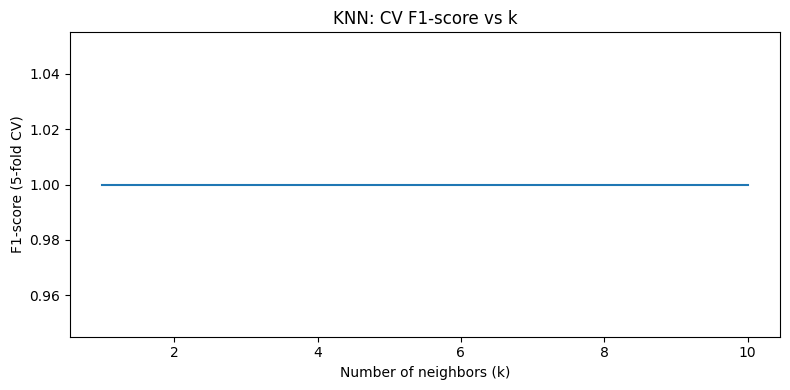

In [25]:
# plot_df = knn_k_results.sort_values("k")

# plt.figure(figsize=(8, 4))
# plt.plot(plot_df["k"], plot_df["f1_score"])
# plt.title("KNN: CV F1-score vs k")
# plt.xlabel("Number of neighbors (k)")
# plt.ylabel("F1-score (5-fold CV)")
# plt.tight_layout()
# plt.show()


In [26]:
# best_k = int(knn_k_results.iloc[0]["k"])
# print("Best k:", best_k)
# print("Best CV Accuracy:", f'{knn_k_results.iloc[0]["accuracy_%"]:.3f}%')
# print("Best CV F1:", f'{knn_k_results.iloc[0]["f1_score"]:.5f}')
# print("Best CV ROC-AUC:", f'{knn_k_results.iloc[0]["roc_auc"]:.5f}')


Best k: 1
Best CV Accuracy: 100.000%
Best CV F1: 1.00000
Best CV ROC-AUC: 1.00000


**!Conclusion:**
The hyperparameter search shows that all tested values of k (from 1 to 10) achieve identical, perfect performance under 5-fold stratified cross-validation: 100% accuracy, F1-score = 1.0, and ROC-AUC = 1.0. This indicates that the dataset is extremely well-separated after preprocessing (one-hot encoding + scaling), so the KNN classifier is not sensitive to the choice of k within this range. In practice, this means we can select a simple value such as k = 1 (or any small k in the tested range) without sacrificing performance, while keeping the model straightforward and computationally efficient.

#### 8.1.2. Model Explanation (Why KNN can work well here)

Unlike Decision Trees and Random Forests, KNN does not learn feature importance or explicit rules. Instead, it classifies each sample by looking at the closest training samples in the transformed feature space.

After preprocessing:

* categorical features are one-hot encoded, so similarity mainly depends on matching categories,

* numeric features are scaled, so no single numeric variable dominates the distance.

This makes KNN suitable for the mushroom dataset, where mushrooms with similar cap/gill/stem patterns tend to share the same class.

**!Conclusion:**
KNN decisions are based on neighborhood similarity rather than learned feature weights. In this dataset, performance remains perfect across the tested range (k = 1–10), suggesting the classes are highly separable after preprocessing and KNN is not sensitive to the choice of k within this range.

#### 8.1.3. Train KNN pipeline

I build a pipeline that applies the same preprocessing steps and then trains a K-Nearest Neighbors (KNN) classifier.
KNN is a distance-based method, so scaling numerical features is important; using the pipeline ensures preprocessing is learned from the training set and applied consistently during prediction.

In [27]:
knn_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", KNeighborsClassifier(
        n_neighbors=1,
        weights="distance", # gives more weight to closer neighbors
        metric="minkowski", # Euclidean when p=2 (default)
        n_jobs=-1
    ))
])

knn_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color',
                                                   'does-bruise-or-bleed',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-color',
                                                   'stem-root', 'stem-surface',
                                                   'stem-color', 'veil-type',
                                                   'veil-color', 'has-ring',
                                                   'ring-type',
                                                   'spore-print-color',
                                                   'habitat', 'season'])])),
                ('clf',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=1,
                                      weights='distance'))])

#### 8.1.4. Predicting over test set

I use the trained KNN pipeline to predict labels for the test set and evaluate performance using accuracy, F1-score, precision, and recall. I also print a full classification report to see how well the model performs on each class (edible vs. poisonous).

In [21]:
# Predict on the held-out test set
y_pred = knn_model.predict(X_test)

# Compute evaluation metrics
acc_knn = accuracy_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)
prec_knn = precision_score(y_test, y_pred)
rec_knn = recall_score(y_test, y_pred)

print(f"Accuracy : {acc_knn *100:.3f}%")
print(f"F1-score  : {f1_knn:.5f}")
print(f"Precision : {prec_knn:.5f}")
print(f"Recall    : {rec_knn:.5f}\n")

# Detailed per-class performance
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["edible (0)", "poisonous (1)"]))

Accuracy : 100.000%
F1-score  : 1.00000
Precision : 1.00000
Recall    : 1.00000

Classification Report:
               precision    recall  f1-score   support

   edible (0)       1.00      1.00      1.00      5436
poisonous (1)       1.00      1.00      1.00      6749

     accuracy                           1.00     12185
    macro avg       1.00      1.00      1.00     12185
 weighted avg       1.00      1.00      1.00     12185



**!Conclusion:** The KNN model achieves perfect performance on the test set, with 100% accuracy and F1 = 1.0, meaning it classifies every sample correctly. Precision and recall are both 1.0 for both classes, showing there are no false positives or false negatives for either edible or poisonous mushrooms.

#### 8.1.5. Confusion Matrix

I plot a confusion matrix to visualize how many samples the KNN classified correctly and where it made mistakes (edible vs. poisonous). This helps us understand the types of errors beyond the overall accuracy.

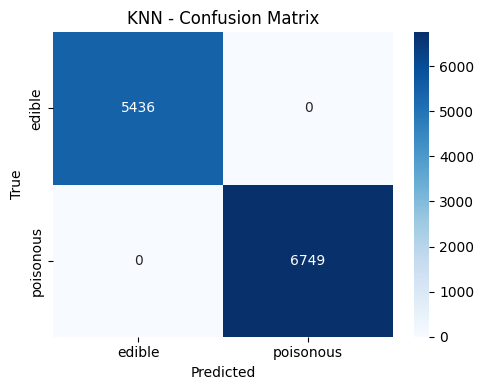

In [22]:
# Build confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["edible", "poisonous"],
            yticklabels=["edible", "poisonous"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("KNN - Confusion Matrix")
plt.tight_layout()
plt.show()

**!Conclusion:**
KNN achieved perfect performance on the test set (no misclassifications). Since the train/test sets are disjoint and the target variable was not included in the features or preprocessing columns, this suggests the dataset is highly separable after one-hot encoding and scaling. The model’s stability across different values of k indicates that class neighborhoods are very consistent, meaning samples of the same class are strongly clustered in the transformed feature space.

In [45]:
# Adding the KNN Results to the all_models list
knn_results = {"model": "KNN", "test_acc": round(acc_knn * 100, 3), "test_f1": round(f1_knn, 5)}
all_models.append(knn_results)

In [46]:
all_models

[{'model': 'KNN', 'test_acc': 100.0, 'test_f1': 1.0}]

### 8.2. Support Vector Machine Classifier (SVM)

#### 8.2.1. Train SVM pipeline

I build a pipeline that applies the same preprocessing steps and then trains a Support Vector Machine (SVM) classifier.
SVM is sensitive to feature scale, so using the pipeline ensures that one-hot encoding and scaling are applied consistently and learned only from the training set.

In [29]:
svm_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SVC(
        kernel="rbf",        # non-linear, often strong baseline
        C=1.0,               # regularization strength
        gamma="scale",       # default good choice for RBF
        probability=True,    # enables ROC-AUC via predict_proba
        random_state=42
    ))
])

svm_model.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color',
                                                   'does-bruise-or-bleed',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-color',
                                                   'stem-root', 'stem-surface',
                                                   'stem-color', 'veil-type',
                                                   'veil-color', 'has-ring',
                                                   'ring-type',
                                                   'spore-print-color',
                                                   'habitat', 'season'])])),
                ('clf', SVC(probability=True, random_state=42))])

#### 8.2.2. Model Explanation

SVM does not provide “feature importance” like Decision Trees or Random Forests. Instead, it learns a decision boundary that maximizes the margin between classes. With an RBF kernel, SVM can model non-linear class boundaries by implicitly mapping the data into a higher-dimensional space.

After preprocessing:

categorical variables are one-hot encoded, turning each category into a separate binary feature,

numerical variables are scaled, which is critical because SVM relies on distances and dot products.

This makes SVM a strong model for this dataset because it can exploit complex patterns in the encoded mushroom features while controlling overfitting through regularization.


**!Conclusion:**
SVM classifies mushrooms by learning a maximum-margin decision boundary. Its performance is mainly influenced by the hyperparameters C (regularization) and gamma (kernel width for RBF), as well as the preprocessing that ensures features are comparable in scale.

#### 8.2.3. Predicting over test set

I use the trained SVM pipeline to predict labels for the test set and evaluate performance using accuracy, F1-score, precision, and recall. I also print a full classification report to see how well the model performs on each class (edible vs. poisonous)

In [30]:
# Predict on the held-out test set
y_pred = svm_model.predict(X_test)

# Compute evaluation metrics
acc_svm = accuracy_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred)
prec_svm = precision_score(y_test, y_pred)
rec_svm = recall_score(y_test, y_pred)

print(f"Accuracy : {acc_svm *100:.3f}%")
print(f"F1-score  : {f1_svm:.5f}")
print(f"Precision : {prec_svm:.5f}")
print(f"Recall    : {rec_svm:.5f}\n")

# Detailed per-class performance
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["edible (0)", "poisonous (1)"]))

Accuracy : 99.967%
F1-score  : 0.99970
Precision : 0.99941
Recall    : 1.00000

Classification Report:
               precision    recall  f1-score   support

   edible (0)       1.00      1.00      1.00      5436
poisonous (1)       1.00      1.00      1.00      6749

     accuracy                           1.00     12185
    macro avg       1.00      1.00      1.00     12185
 weighted avg       1.00      1.00      1.00     12185



#### 8.2.4. Confusion Matrix

I plot a confusion matrix to visualize how many samples the SVM classified correctly and where it made mistakes (edible vs. poisonous). This helps us understand the types of errors beyond the overall accuracy.

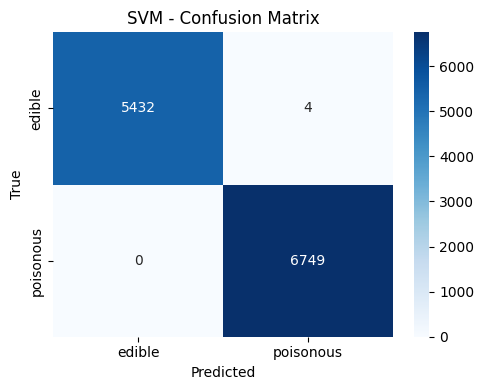

In [31]:
# Build confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["edible", "poisonous"],
            yticklabels=["edible", "poisonous"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM - Confusion Matrix")
plt.tight_layout()
plt.show()


#### 8.2.5. 2D projection scatter plot (TruncatedSVD)

Because the dataset becomes high-dimensional after one-hot encoding, I project the transformed test set into two dimensions using TruncatedSVD and plot the samples. This visualization helps illustrate how the classes are arranged in the feature space and highlights any misclassified points.

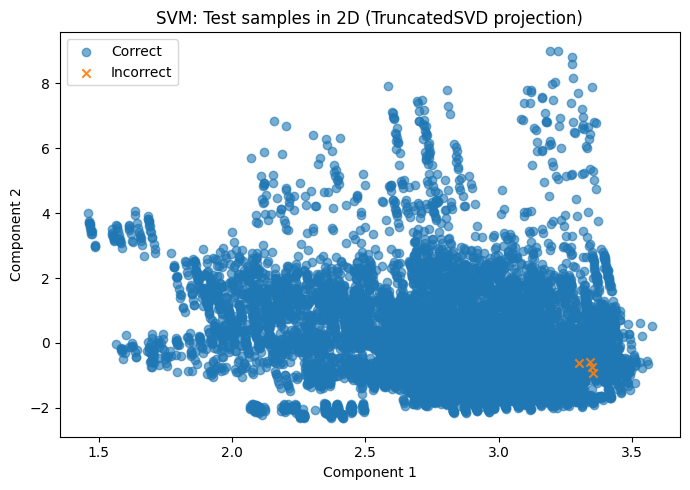

In [37]:
# Transform data using your fitted preprocessing (sparse output is OK)
X_test_tr = svm_model.named_steps["prep"].transform(X_test)

# 2D projection for visualization (better than PCA for sparse one-hot)
svd = TruncatedSVD(n_components=2, random_state=42)
X_test_2d = svd.fit_transform(X_test_tr)

# Correct vs incorrect mask
correct = (y_pred == y_test.to_numpy() if hasattr(y_test, "to_numpy") else y_pred == y_test)

plt.figure(figsize=(7, 5))
plt.scatter(X_test_2d[correct, 0], X_test_2d[correct, 1], alpha=0.6, marker="o", label="Correct")
plt.scatter(X_test_2d[~correct, 0], X_test_2d[~correct, 1], alpha=0.9, marker="x", label="Incorrect")
plt.title("SVM: Test samples in 2D (TruncatedSVD projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.tight_layout()
plt.show()

**!Conclusion:**
The projected points show a clear structure, with only a few misclassifications visible, suggesting that most samples are well separated and that errors occur only in a small ambiguous region of the feature space.

#### 8.2.6. SVM decision function histogram

To better understand how confidently the SVM separates the two classes, I plot the decision function scores on the test set for edible and poisonous mushrooms. These scores represent the signed distance to the separating hyperplane, where negative values indicate one class and positive values indicate the other.

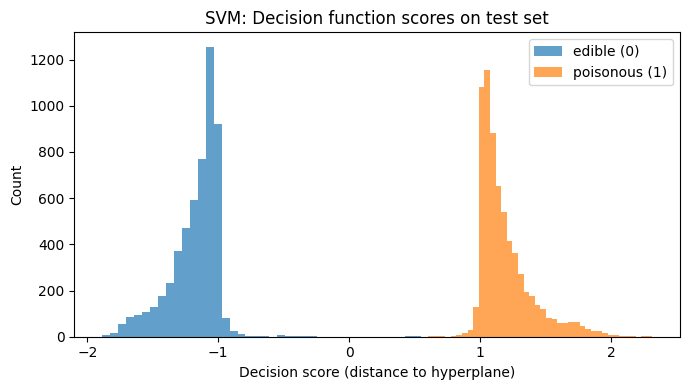

In [35]:
scores = svm_model.decision_function(X_test)

plt.figure(figsize=(7, 4))
plt.hist(scores[y_test==0], bins=40, alpha=0.7, label="edible (0)")
plt.hist(scores[y_test==1], bins=40, alpha=0.7, label="poisonous (1)")
plt.title("SVM: Decision function scores on test set")
plt.xlabel("Decision score (distance to hyperplane)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


**!Conclusion:**
The two score distributions are almost completely separated with very little overlap, showing that the SVM assigns high confidence to most predictions and learns a strong decision boundary between edible and poisonous mushrooms.

In [47]:
# Adding the SVM Results to the all_models list
svm_results = {"model": "SVM", "test_acc": round(acc_svm * 100, 3), "test_f1": round(f1_svm, 5)}
all_models.append(svm_results)

In [48]:
all_models

[{'model': 'KNN', 'test_acc': 100.0, 'test_f1': 1.0},
 {'model': 'SVM', 'test_acc': 99.967, 'test_f1': 0.9997}]

### 8.3. Naive Base Classifier (BernoulliNB)

#### 8.3.1. Hyperparameter tuning (BernoulliNB – smoothing alpha)

I tune the smoothing parameter alpha for Bernoulli Naive Bayes using 5-fold stratified cross-validation. Smoothing prevents zero probabilities for rare categories and can improve generalization. I test several alpha values and select the one with the highest cross-validated F1-score.

In [39]:
alpha_values = [0.05, 0.1, 0.5, 1.0, 2.0]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

rows = []

for a in alpha_values:
    nb_pipe = Pipeline(steps=[
        ("prep", preprocess),
        ("clf", BernoulliNB(alpha=a))
    ])

    scores = cross_validate(nb_pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

    rows.append({
        "alpha": a,
        "accuracy_%": scores["test_accuracy"].mean() * 100,
        "f1_score": scores["test_f1"].mean(),
        "roc_auc": scores["test_roc_auc"].mean(),
    })

In [40]:
nb_alpha_results = pd.DataFrame(rows).sort_values("f1_score", ascending=False).reset_index(drop=True)
nb_alpha_results

,alpha,accuracy_%,f1_score,roc_auc
0,0.05,77.894054,0.795885,0.863332
1,0.10,77.894054,0.795885,0.863332
2,0.50,77.875589,0.795680,0.863319
3,1.00,77.867381,0.795589,0.863278
4,2.00,77.859174,0.795520,0.863137


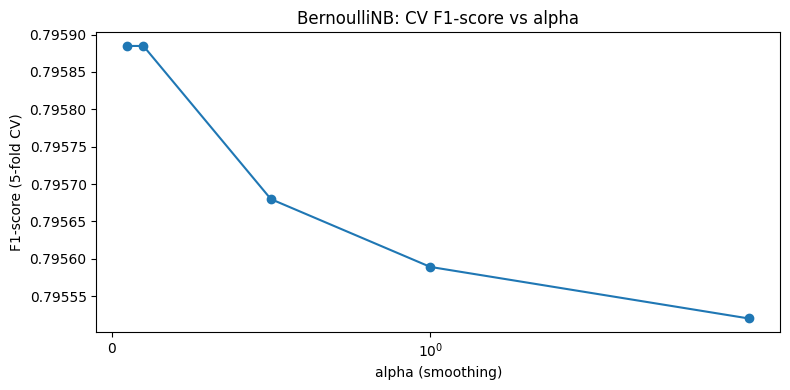

In [41]:
plot_df = nb_alpha_results.sort_values("alpha")

plt.figure(figsize=(8, 4))
plt.plot(plot_df["alpha"], plot_df["f1_score"], marker="o")
plt.xscale("symlog")  # helps visualize small and large alphas together
plt.title("BernoulliNB: CV F1-score vs alpha")
plt.xlabel("alpha (smoothing)")
plt.ylabel("F1-score (5-fold CV)")
plt.tight_layout()
plt.show()


#### 8.3.2. Train Naive Bayes pipeline

In this step, I take the best `alpha` value from the tuning results and train the final Bernoulli Naive Bayes model inside the same preprocessing pipeline. This ensures preprocessing is applied consistently and learned only from the training data.

In [42]:
best_alpha = float(nb_alpha_results.iloc[0]["alpha"])

nb_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", BernoulliNB(alpha=best_alpha))
])
nb_model.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color',
                                                   'does-bruise-or-bleed',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-color',
                                                   'stem-root', 'stem-surface',
                                                   'stem-color', 'veil-type',
                                                   'veil-color', 'has-ring',
                                                   'ring-type',
                                                   'spore-print-color',
                                                   'habitat', 'season'])])),
                ('clf', BernoulliNB(alpha=0.05))])

#### 8.3.3. Model Explanation

Naive Bayes does not provide feature importance like tree-based models. Instead, it is a probabilistic classifier based on Bayes’ theorem and the “naive” assumption that features are conditionally independent given the class.

After preprocessing:

* categorical variables are one-hot encoded, producing many binary (0/1) features,

* BernoulliNB models the probability of observing each binary feature for edible vs. poisonous mushrooms.

This makes Bernoulli Naive Bayes a strong and efficient baseline, especially for high-dimensional sparse data such as one-hot encoded categorical datasets.


**!Conclusion:**
Naive Bayes predicts by comparing class probabilities rather than learning complex decision boundaries. Even with its independence assumption, it can perform very well when individual categorical signals strongly correlate with the target class.

#### 8.3.4. Predicting over test set

I use the trained Naive Bayes pipeline to predict labels for the test set and evaluate performance using accuracy, F1-score, precision, and recall. I also print a full classification report to see how well the model performs on each class (edible vs. poisonous).

In [43]:
# Predict on the held-out test set
y_pred = nb_model.predict(X_test)

# Compute evaluation metrics
acc_nb = accuracy_score(y_test, y_pred)
f1_nb = f1_score(y_test, y_pred)
prec_nb = precision_score(y_test, y_pred)
rec_nb = recall_score(y_test, y_pred)

print(f"Accuracy : {acc_nb *100:.3f}%")
print(f"F1-score  : {f1_nb:.5f}")
print(f"Precision : {prec_nb:.5f}")
print(f"Recall    : {rec_nb:.5f}\n")

# Detailed per-class performance
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["edible (0)", "poisonous (1)"]))


Accuracy : 77.743%
F1-score  : 0.79634
Precision : 0.80737
Recall    : 0.78560

Classification Report:
               precision    recall  f1-score   support

   edible (0)       0.74      0.77      0.75      5436
poisonous (1)       0.81      0.79      0.80      6749

     accuracy                           0.78     12185
    macro avg       0.77      0.78      0.78     12185
 weighted avg       0.78      0.78      0.78     12185



**!Conclusion:** Bernoulli Naive Bayes achieves 77.74% accuracy with F1 = 0.796, showing moderate performance compared to the other models. The model performs better on the poisonous class (F1 = 0.80) than on the edible class (F1 = 0.75), indicating it recognizes poisonous mushrooms more reliably than edible ones.

#### 8.3.5. Confusion Matrix

I plot a confusion matrix to visualize how many samples Naive Bayes classified correctly and where it made mistakes (edible vs. poisonous). This helps us understand the types of errors beyond the overall accuracy.

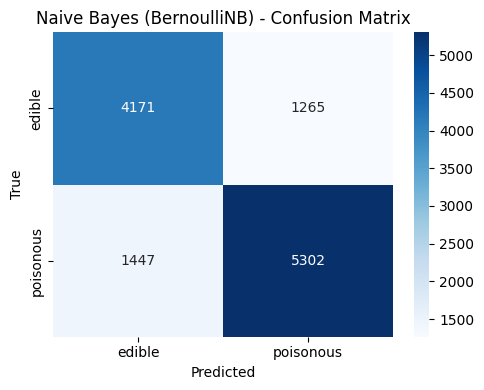

In [44]:
# Build confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["edible", "poisonous"],
            yticklabels=["edible", "poisonous"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Naive Bayes (BernoulliNB) - Confusion Matrix")
plt.tight_layout()
plt.show()

**!Conclusion:** The confusion matrix shows a substantial number of errors in both directions: 1265 edible mushrooms are misclassified as poisonous, and 1447 poisonous mushrooms are misclassified as edible. While the model correctly classifies most samples, these misclassifications highlight the limitation of Naive Bayes on this dataset, especially because predicting poisonous mushrooms as edible is the most critical type of mistake.

In [49]:
# Adding the Naive Base Results to the all_models list
nb_results = {"model": "Naive Base", "test_acc": round(acc_nb * 100, 3), "test_f1": round(f1_nb, 5)}
all_models.append(nb_results)

In [50]:
all_models

[{'model': 'KNN', 'test_acc': 100.0, 'test_f1': 1.0},
 {'model': 'SVM', 'test_acc': 99.967, 'test_f1': 0.9997},
 {'model': 'Naive Base', 'test_acc': 77.743, 'test_f1': 0.79634}]

## 9. Final Conclusion (Model Comparison)

In this section, I convert the saved results into a table and visualize the models’ test accuracy and test F1-score side by side. This makes it easier to compare overall performance and choose the best classifier.

In [51]:
# Convert to DataFrame and show it
df_compare = pd.DataFrame(all_models)
df_compare

,model,test_acc,test_f1
0,KNN,100.000,1.00000
1,SVM,99.967,0.99970
2,Naive Base,77.743,0.79634


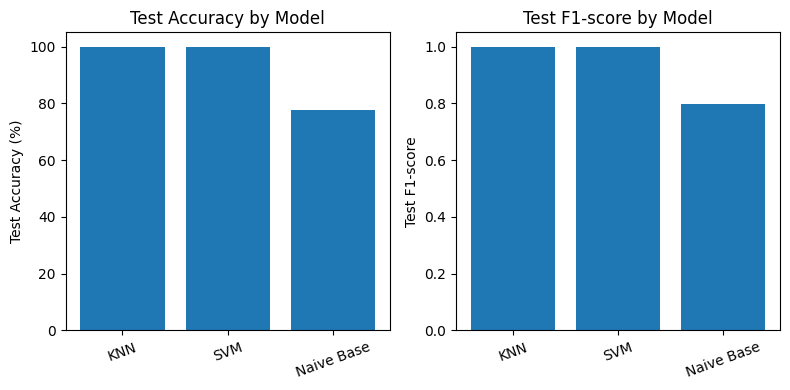

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Accuracy plot
axes[0].bar(df_compare["model"], df_compare["test_acc"])
axes[0].set_title("Test Accuracy by Model")
axes[0].set_ylabel("Test Accuracy (%)")
axes[0].tick_params(axis="x", rotation=20)

# F1 plot
axes[1].bar(df_compare["model"], df_compare["test_f1"])
axes[1].set_title("Test F1-score by Model")
axes[1].set_ylabel("Test F1-score")
axes[1].tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

**!Final Conclusion:**

Both the table and the bar charts confirm that KNN is the top-performing model with 100.000% test accuracy and F1 = 1.00000, while SVM is almost identical with 99.967% accuracy and F1 = 0.99970, showing only a negligible drop. In contrast, Naive Bayes is clearly weaker (77.743% accuracy, F1 = 0.79634), indicating that its independence assumption limits its ability to model the strong feature interactions present in the mushroom dataset.